In [28]:
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest

import imblearn as imb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.keras import BalancedBatchGenerator

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
import ast

from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout, BatchNormalization # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy # type: ignore
from keras.metrics import Accuracy, AUC # type: ignore
from keras.callbacks import EarlyStopping # type: ignore



## Erythromycin

In [8]:
df = pd.read_csv('../data/practica_micro.csv')

# Create a new DataFrame with 6000 columns from the 'MALDI_binned' column
df['MALDI_binned'] = df['MALDI_binned'].apply(ast.literal_eval)
maldi_binned_df = pd.DataFrame(df['MALDI_binned'].tolist(), index=df.index)
df_expanded = pd.concat([maldi_binned_df, df.drop(columns=['MALDI_binned'])], axis=1)
df_expanded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5962,5963,5964,5965,5966,5967,5968,5969,5970,5971,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984,5985,5986,5987,5988,5989,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999,Erythromycin,Ciprofloxacin
0,0.000254,0.000395,0.000453,0.000495,0.000801,0.000879,0.001296,0.000631,0.000040,0.000295,0.000369,0.001278,0.001768,0.000413,0.000317,0.000162,0.000188,0.000629,0.000108,0.000398,0.000786,0.000790,0.004846,0.004197,0.001235,0.000907,0.000749,0.001577,0.001408,0.000702,0.000908,0.000474,0.000434,0.000215,0.001087,0.003671,0.002406,0.000327,0.000323,0.000452,...,0.000018,0.000004,0.000003,0.000047,0.000058,0.000071,0.000082,0.000106,0.000069,0.000067,0.000064,0.000075,0.000017,0.000008,0.000009,0.000014,0.000029,0.000032,0.000063,1.204154e-04,0.000072,0.000068,0.000068,0.000093,0.000064,0.000031,0.000006,0.000004,3.847418e-07,0.000005,0.000023,0.000062,0.000061,0.000056,0.000071,0.000052,0.000044,0.000025,0.0,0.0
1,0.000339,0.000203,0.000097,0.000844,0.000769,0.000667,0.000974,0.000557,0.000116,0.000038,0.000812,0.001888,0.001096,0.000343,0.000144,0.000022,0.000265,0.000268,0.000160,0.000407,0.000471,0.002459,0.004366,0.002007,0.000521,0.000150,0.001120,0.001391,0.001676,0.002199,0.000736,0.000178,0.000099,0.000134,0.001681,0.002782,0.001076,0.000131,0.000127,0.000400,...,0.000068,0.000066,0.000102,0.000060,0.000068,0.000080,0.000119,0.000058,0.000047,0.000035,0.000026,0.000002,0.000007,0.000028,0.000051,0.000028,0.000029,0.000038,0.000073,5.727302e-05,0.000065,0.000098,0.000056,0.000043,0.000038,0.000070,0.000064,0.000065,6.344351e-05,0.000070,0.000056,0.000074,0.000096,0.000154,0.000075,0.000067,0.000042,0.000022,0.0,0.0
2,0.000123,0.000162,0.000089,0.000671,0.000563,0.001250,0.001091,0.000240,0.000078,0.000060,0.000769,0.002504,0.001477,0.000710,0.000193,0.000243,0.000706,0.000217,0.000127,0.000603,0.000318,0.003928,0.006222,0.002374,0.000975,0.000538,0.001292,0.001395,0.000501,0.000927,0.000968,0.000356,0.000093,0.000575,0.003753,0.003459,0.001051,0.000158,0.000252,0.000185,...,0.000031,0.000056,0.000035,0.000046,0.000062,0.000091,0.000058,0.000073,0.000079,0.000124,0.000080,0.000065,0.000045,0.000032,0.000008,0.000023,0.000031,0.000047,0.000057,6.375351e-05,0.000049,0.000055,0.000049,0.000057,0.000064,0.000085,0.000033,0.000030,1.657958e-05,0.000006,0.000029,0.000055,0.000112,0.000084,0.000072,0.000060,0.000046,0.000003,1.0,0.0
3,0.000282,0.000608,0.000158,0.000486,0.000495,0.000468,0.000414,0.000147,0.000160,0.000277,0.000366,0.000747,0.000689,0.000531,0.000115,0.000133,0.000317,0.000317,0.000241,0.000120,0.000077,0.001126,0.001816,0.000597,0.000297,0.000636,0.001470,0.001298,0.000755,0.000763,0.000270,0.000061,0.000407,0.000442,0.001028,0.001111,0.000261,0.000239,0.000815,0.000772,...,0.000004,0.000014,0.000023,0.000018,0.000031,0.000036,0.000048,0.000033,0.000032,0.000033,0.000052,0.000026,0.000026,0.000025,0.000024,0.000016,0.000020,0.000021,0.000037,2.242340e-05,0.000026,0.000059,0.000041,0.000048,0.000056,0.000098,0.000064,0.000056,4.959213e-05,0.000073,0.000037,0.000015,0.000003,0.000004,0.000021,0.000036,0.000045,0.000096,0.0,1.0
4,0.000370,0.000243,0.000149,0.000620,0.000307,0.000999,0.000981,0.000304,0.000262,0.000104,0.000542,0.002032,0.001384,0.000076,0.000295,0.000353,0.000877,0.000701,0.000196,0.000414,0.000661,0.002510,0.005224,0.002529,0.000431,0.000257,0.001152,0.002327,0.001669,0.000877,0.001042,0.000806,0.000299,0.000142,0.001883,0.003137,0.001184,0.000228,0.000027,0.000151,...,0.000021,0.000037,0.000058,0.000039,0.000041,0.000043,0.000057,0.000047,0.000042,0.000052,0.000087,0.000073,0.000086,0.000084,0.000122,0.000065,0.000050,0.000040,0.000022,5.832555e-07,0.000007,0.000014,0.000031,0.000028,0.000041,0.000086,0.000053,0.000058,6.183159e-05,0.000086,0.000050,0.000037,0.000025,0.000051,0.000056,0.000078,0.000099,0.000140,0.0,0.0


In [22]:
# Definir conjuntos x e y
X = df_expanded.drop(columns=['Erythromycin', 'Ciprofloxacin'])
y = df_expanded['Erythromycin']

X_train = X.sample(frac=0.8, replace=False)
X_test = X.drop(X_train.index)
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=73, stratify=y_train)

# Tamaños de los datasets resultantes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1108, 6000)
X_val shape: (277, 6000)
X_test shape: (346, 6000)
y_train shape: (1108,)
y_val shape: (277,)
y_test shape: (346,)


Epoch 1/50


c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc_13: 0.5253 - loss: 0.5913 - val_auc_13: 0.5008 - val_loss: 0.1573
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc_13: 0.6826 - loss: 0.3067 - val_auc_13: 0.4984 - val_loss: 0.2397
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc_13: 0.7665 - loss: 0.2307 - val_auc_13: 0.4865 - val_loss: 0.2518
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc_13: 0.8351 - loss: 0.1839 - val_auc_13: 0.5188 - val_loss: 0.7926
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc_13: 0.9116 - loss: 0.1164 - val_auc_13: 0.5354 - val_loss: 0.3555
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc_13: 0.9199 - loss: 0.1047 - val_auc_13: 0.5471 - val_loss: 0.3078


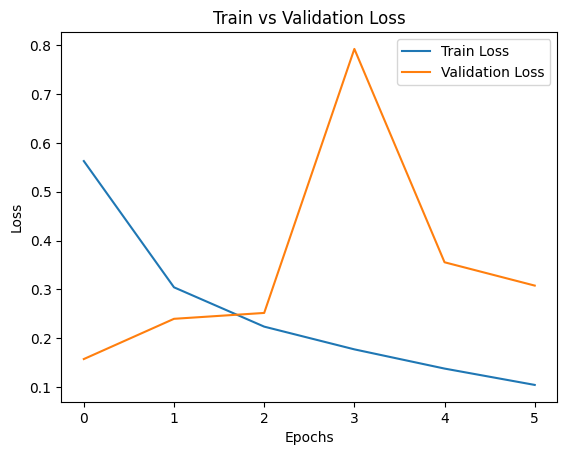

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Balanced Accuracy: 0.503887545631252


In [ ]:
# Crear el pipeline con MinMaxScaler y PCA
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', KernelPCA(n_components=1000))  # Retener el 95% de la varianza
])

# Ajustar el pipeline en el conjunto de entrenamiento y transformar los datos
X_train_scaled = pipeline.fit_transform(X_train)
# Aplicar la misma transformación al conjunto de valid y test
X_val_scaled = pipeline.transform(X_val)
X_test_scaled = pipeline.transform(X_test)

training_generator = BalancedBatchGenerator(
    X_train_scaled, y_train, sampler=RandomUnderSampler(), batch_size=32, random_state=73
)

model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Prueba también tanh
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryFocalCrossentropy(), metrics=[AUC()])

# Early stopping para prevenir overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    training_generator,
    epochs=50,  # Puedes aumentar las épocas para observar mejor el overfitting
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Graficar pérdidas para detectar overfitting
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

# Predecir en test
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
print(f"Balanced Accuracy: {balanced_accuracy}")